In [1]:
%matplotlib inline
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()

In [101]:
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
    print center

    r = np.hypot(x - center[0], y - center[1])
    print r

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

def radial_profile(data,dx=1.0,center=None):
    y, x = np.indices((data.shape))
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    maxdist = len(radialprofile)*np.sqrt(2)*dx
    dist = np.linspace(0,maxdist,len(radialprofile))
    return dist,radialprofile

In [105]:
lx = 32.0
ly = 32.0
nx = 128
ny = 128
x = np.linspace(0,lx,nx)
y = np.linspace(0,ly,ny)
X,Y = np.meshgrid(x,y)
stripes = np.exp(1j*((2.0*np.pi)/16)*(X)).real
hexagons = np.exp(1j*((2.0*np.pi)/16)*X) + np.exp(-1j*(((2.0*np.pi)/32)*X+((np.sqrt(3)*2.0*np.pi)/32)*Y)) + np.exp(-1j*(((2.0*np.pi)/32)*X-((np.sqrt(3)*2.0*np.pi)/32)*Y))
hexagons = hexagons.real

In [102]:
def calcTypicalDistance(image,lx=1.0,ly=1.0):
    dx = lx/len(image[0])
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)
    
    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift(F1)
    
    # Calculate a 2D power spectrum
    psd2D = np.fabs(F2.real)**2
    
    # Calculate the azimuthally averaged 1D power spectrum
    #psd1D = azimuthalAverage(psd2D)
    psd1D = radial_profile(psd2D,dx)
    return psd1D

    

def plotPSD(image):
    fig,ax = plt.subplots(1,3,figsize=(3*3,3))
    
    # Take the fourier transform of the image.
    F1 = fftpack.fft2(image)
    
    # Now shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image.
    F2 = fftpack.fftshift(F1)
    
    # Calculate a 2D power spectrum
    psd2D = np.fabs(F2.real)**2
    
    # Calculate the azimuthally averaged 1D power spectrum
    #psd1D = azimuthalAverage(psd2D)
    dist,psd1D = radial_profile(psd2D)
    
    # Now plot up both
    ax[0].imshow(image, origin='lower')
    ax[1].imshow(psd2D, origin='lower')
    ax[2].semilogy(psd1D )
    plt.tight_layout()
    #plt.xlabel('Spatial Frequency')
    #plt.ylabel('Power Spectrum')

0.3575259006
0.392699081699


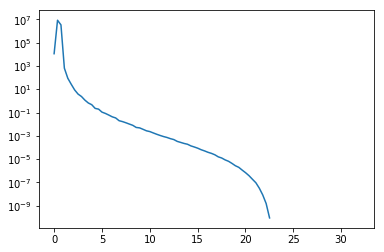

In [106]:
dist,stripes_rad = calcTypicalDistance(stripes,lx,ly)
print dist[np.argmax(stripes_rad)]
print (2.0*np.pi)/16.0
plt.semilogy(dist,stripes_rad)

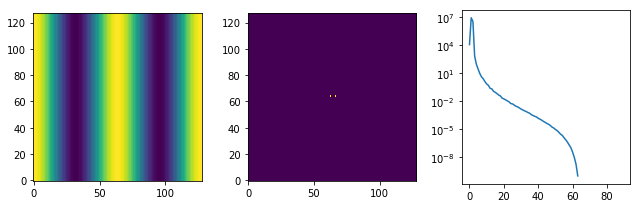

In [107]:
plotPSD(stripes)

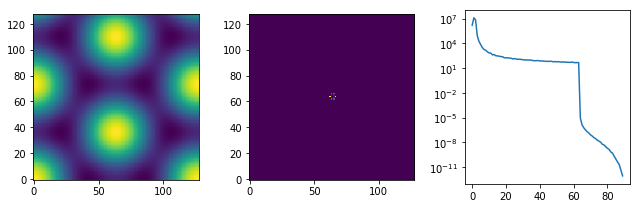

In [108]:
plotPSD(hexagons)